# Helicóptero de Bancada para disciplina de Controle e Aplicações

## Preparação

In [626]:
# Bibliotecas
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import ipywidgets as widgets
from ipywidgets import interactive
from scipy.optimize import minimize
from IPython.display import Latex
from tbcontrol.symbolic import routh
from scipy.integrate import solve_ivp
from scipy.signal import place_poles
from scipy.signal import find_peaks

import control as ct
s = ct.tf('s')

from seaborn import color_palette
colors = color_palette()

In [627]:
# Definição dos símbolos
m_c, m_m, a, l, L, K, g = sp.symbols('m_c m_m a l L K g')
epsilon, alpha, theta = sp.symbols('epsilon alpha theta')
d_epsilon, d_alpha, d_theta = sp.symbols('d_epsilon d_alpha d_theta')
dd_epsilon, dd_alpha, dd_theta = sp.symbols('dd_epsilon dd_alpha dd_theta')
V_D, V_E = sp.symbols('V_D V_E')
M_P_x, M_P_y, M_P_z = sp.symbols('M_P_x M_P_y M_P_z')
rho, C_D, U, S, beta = sp.symbols('rho C_D U S beta')
x1, x2, x3, x4, x5, x6 = sp.symbols('x1 x2 x3 x4 x5 x6') 
u1, u2 = sp.symbols('u1 u2')                              
w1, w2, w3 = sp.symbols('w1 w2 w3')                        
epsilon_linha, alpha_linha, theta_linha = sp.symbols('epsilon_linha alpha_linha theta_linha')
s = sp.symbols('s')

I = sp.eye(6)

In [628]:
# Parametros
params = {
    m_c: 1.565,
    m_m: 0.355,
    l: 0.45,
    L: 0.64,
    K: 0.5839,
    g: 9.81,
    a: 0.275,
    rho: 1.225,
    C_D: 1,
    S: 0.00196,
    beta: 10*np.pi/180,
    U: 5,
    #epsilon_linha: 4*np.pi/180,
    #alpha_linha: 1*np.pi/180,
    theta_linha: 2*np.pi/180
}

In [629]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839,0.0,0.027),
    'dgreen': (0.341,0.494,0.094),
    'dblue': (0.063,0.318,0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [693]:
vestados = ["$\\varepsilon$", "$\\alpha$", "$\\theta$", "$\dot{\\varepsilon}$", "$\dot{\\alpha}$", "$\dot{\\theta}$"]
vestadosE = ["$\\hat{\\varepsilon}$", "$\\hat{\\alpha}$", "$\\hat{\\theta}$", "$\\hat{\dot{\\varepsilon}}$", "$\\hat{\dot{\\alpha}}$", "$\\hat{\dot{\\theta}}$"]
vestadosR = ["$\\varepsilon_{\\text{ref}}$", "$\\alpha_{\\text{ref}}$", "$\\theta_{\\text{ref}}$", "$\dot{\\varepsilon}_{\\text{ref}}$", "$\dot{\\alpha}_{\\text{ref}}$", "$\dot{\\theta}_{\\text{ref}}$"]
ventrada = ["$V_D$", "$V_E$"]

## Modelagem Matemática

In [631]:
# Vetores unitários
i = sp.Matrix([1, 0, 0])
j = sp.Matrix([0, 1, 0])
k = sp.Matrix([0, 0, 1])

# Matrizes de rotação
R_x = sp.Matrix([
    [1, 0, 0],
    [0, sp.cos(epsilon), -sp.sin(epsilon)],
    [0, sp.sin(epsilon), sp.cos(epsilon)]
])

R_y = sp.Matrix([
    [sp.cos(alpha), 0, sp.sin(alpha)],
    [0, 1, 0],
    [-sp.sin(alpha), 0, sp.cos(alpha)]
])

R_z = sp.Matrix([
    [sp.cos(theta), -sp.sin(theta), 0],
    [sp.sin(theta), sp.cos(theta), 0],
    [0, 0, 1]
])

R = R_x * R_y * R_z

# Vetores de posição
rc = -l * j
r = L * j
rd = r + a * i
re = r - a * i

# Momentos de inércia
Ixx = m_c*l**2 + 2*m_m*L**2
Iyy = 2*m_m*a**2
Izz = m_c*l**2 + 2*m_m*(a**2 + L**2)
J = sp.diag(Ixx, Iyy, Izz)

M_P = M_P_x*i + M_P_y*j + M_P_z*k

# Velocidade e aceleração angular
omega = d_epsilon*i + d_alpha*j + d_theta*k
d_omega = dd_epsilon*i + dd_alpha*j + dd_theta*k

# Pesos
Pc = R * (m_c * g * k)
Pm = R * (m_m * g * k)

# Equilíbrio de forças
Fc = Pc
Fd = Pm + K * V_D * k
Fe = Pm + K * V_E * k

# Arrasto
U_vet = R * (U * (sp.cos(beta) * i + sp.sin(beta) * j))
v_rel = U_vet - omega.cross(r)
modulo_v_rel2 = v_rel.dot(v_rel)
direcao_v_rel = v_rel / sp.sqrt(modulo_v_rel2)
Fa = 0.5 * rho * C_D * modulo_v_rel2 * S * direcao_v_rel

# Soma dos momentos
somatorio_momentos = rc.cross(Fc) + re.cross(Fe) + rd.cross(Fd) + r.cross(Fa) + M_P

# Resolução das EDOs
eqs = somatorio_momentos - (J * d_omega + omega.cross(J * omega))
sol = sp.solve(eqs, (dd_epsilon, dd_alpha, dd_theta), dict=True)[0]

d_d_epsilon = sp.simplify(sol[dd_epsilon])
d_d_alpha = sp.simplify(sol[dd_alpha])
d_d_theta = sp.simplify(sol[dd_theta])

### EDOs do sistema

In [632]:
display(Latex(f'$\\ddot{{\\varepsilon}} = {sp.latex(d_d_epsilon)}$'))
display(Latex(f'$\\ddot{{\\alpha}} = {sp.latex(d_d_alpha)}$'))
display(Latex(f'$\\ddot{{\\theta}} = {sp.latex(d_d_theta)}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [633]:
# Substituições para forma de espaço de estados
d_x4 = d_d_epsilon.subs([
    (epsilon, x1), (alpha, x2), (theta, x3),
    (d_epsilon, x4), (d_alpha, x5), (d_theta, x6),
    (V_D, u1), (V_E, u2),
    (M_P_x, w1), (M_P_y, w2), (M_P_z, w3)
])

d_x5 = d_d_alpha.subs([
    (epsilon, x1), (alpha, x2), (theta, x3),
    (d_epsilon, x4), (d_alpha, x5), (d_theta, x6),
    (V_D, u1), (V_E, u2),
    (M_P_x, w1), (M_P_y, w2), (M_P_z, w3)
])

d_x6 = d_d_theta.subs([
    (epsilon, x1), (alpha, x2), (theta, x3),
    (d_epsilon, x4), (d_alpha, x5), (d_theta, x6),
    (V_D, u1), (V_E, u2),
    (M_P_x, w1), (M_P_y, w2), (M_P_z, w3)
])

# Vetores de estado e entrada
x = sp.Matrix([x1, x2, x3, x4, x5, x6])
u = sp.Matrix([u1, u2])
w = sp.Matrix([w1, w2, w3])

# Equações de estado e saída
f = sp.Matrix([x4, x5, x6, d_x4, d_x5, d_x6])
h = sp.Matrix([x1, x2, x3])

## Ponto de Equilíbrio

In [634]:
# Ponto de equilíbrio
subs_eq = {
    x1: epsilon_linha,
    x2: alpha_linha,
    x3: theta_linha,
    x4: 0,
    x5: 0,
    x6: 0,
    w1: 0,
    w2: 0,
    w3: 0
}

ddX_eq = f.subs(subs_eq)
sol_eq = sp.solve([
    ddX_eq[3].simplify(),  # d_x4 == 0
    ddX_eq[4].simplify()   # d_x5 == 0
], (u1, u2), dict=True)[0]

u1_eq = sp.simplify(sol_eq[u1])
u2_eq = sp.simplify(sol_eq[u2])

In [635]:
display(Latex(f'$u_{{1_{{eq}}}} = {sp.latex(u1_eq)}$'))
display(Latex(f'$u_{{2_{{eq}}}} = {sp.latex(u2_eq)}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Espaço de Estados Linearizado

In [636]:
# Linearizacao
A = f.jacobian(x)
B = f.jacobian(u)
E = f.jacobian(w)
C = h.jacobian(x)
D = h.jacobian(u)

# Substituições completas com entradas e perturbações de equilíbrio
subs_all_eq = dict(subs_eq)
subs_all_eq[u1] = u1_eq
subs_all_eq[u2] = u2_eq

# Avaliação dos Jacobianos no ponto de equilíbrio
A = A.subs(subs_all_eq)
B = B.subs(subs_all_eq)
C = C.subs(subs_all_eq)
D = D.subs(subs_all_eq)
E = E.subs(subs_all_eq)

In [637]:
display(Latex(f'$A = {sp.latex(A)}$'))
display(Latex(f'$B = {sp.latex(B)}$'))
display(Latex(f'$C = {sp.latex(C)}$'))
display(Latex(f'$D = {sp.latex(D)}$'))
display(Latex(f'$E = {sp.latex(E)}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [638]:
# Aproximação para pequenos ângulos: sin(a) = a, cos(a)=1, sin(a+b)=a+b e cos(a+b)=1-a*b
small_angle_subs = {
    sp.sin(epsilon_linha): epsilon_linha,
    sp.cos(epsilon_linha): 1,
    sp.sin(alpha_linha): alpha_linha,
    sp.cos(alpha_linha): 1,
    sp.sin(beta + theta_linha): beta + theta_linha,
    sp.cos(beta + theta_linha): 1 - beta * theta_linha
}

A = sp.simplify(A.subs(small_angle_subs))
B = sp.simplify(B.subs(small_angle_subs))
C = sp.simplify(C.subs(small_angle_subs))
D = sp.simplify(D.subs(small_angle_subs))
E= sp.simplify(E.subs(small_angle_subs))

In [639]:
display(Latex(f'$A = {sp.latex(A)}$'))
display(Latex(f'$B = {sp.latex(B)}$'))
display(Latex(f'$C = {sp.latex(C)}$'))
display(Latex(f'$D = {sp.latex(D)}$'))
display(Latex(f'$E = {sp.latex(E)}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [640]:
# Substitituicao numerica
A_num = A.subs(params).evalf()
B_num = B.subs(params).evalf()
C_num = C.subs(params).evalf()
D_num = D.subs(params).evalf()
E_num = E.subs(params).evalf()

### Ordens do sistema

In [641]:
n = A_num.shape[0]
r = B_num.shape[1]
m = C_num.shape[0]
l = E_num.shape[1]

print("n - Ordem do sistema:", n)
print("r - Ordem da entrada:", r)
print("m - Ordem da saída:", m)
print("l - Ordem da perturbação:", l)

n - Ordem do sistema: 6
r - Ordem da entrada: 2
m - Ordem da saída: 3
l - Ordem da perturbação: 3


## Análise de Estabilidade

In [642]:
p = sp.simplify(A_num.charpoly('s'))
p

PurePoly(1.0*s**6 + (0.0039964518169993*alpha_linha**2 - 0.00168429111074122*alpha_linha*epsilon_linha + 0.000177459698979425*epsilon_linha**2 + 0.0114347965906679)*s**5 + (1.48555213437681e-5*alpha_linha**2 - 0.0314199236077218*alpha_linha*epsilon_linha + 6.59649225503965e-7*epsilon_linha**2 - 4.03309783891985*epsilon_linha - 0.0126719149803521)*s**4 + (-3.3881317890172e-21*alpha_linha**2 - 0.00011164805242729*alpha_linha*epsilon_linha - 2.53866384789675e-5*epsilon_linha**2 - 0.0298013688584842*epsilon_linha - 7.35196813385181e-5)*s**3 + (5.29395592033938e-23*alpha_linha**2*epsilon_linha**2 + 5.42101086242752e-20*alpha_linha**2*epsilon_linha - 7.94093388050907e-23*alpha_linha**2 + 9.92616735063633e-24*alpha_linha*epsilon_linha**3 - 1.01643953670516e-20*alpha_linha*epsilon_linha**2 + 0.000191064735730922*alpha_linha*epsilon_linha + 0.0245301790406917*epsilon_linha + 4.0261793548826e-5)*s**2, s, domain='RR[alpha_linha,epsilon_linha]')

In [643]:
RHm = routh(p)
RHm

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [644]:
RHm.subs({sp.nan: 0, alpha_linha: 2*np.pi/180, epsilon_linha:-0.3275*np.pi/180})

Matrix([
[                 1.0,    0.010387371086653, -9.99896863739711e-5, 0],
[  0.0114400080012061,  9.68449984174697e-5,                    0, 0],
[ 0.00192190511781283, -9.99896863739711e-5,                    0, 0],
[0.000692026728022353,                    0,                    0, 0],
[ -9.9989686373971e-5,                    0,                    0, 0],
[                   0,                    0,                    0, 0],
[                   0,                    0,                    0, 0]])

In [645]:
# Adicionando os valores de alpha_linha e epsilon_linha que melhor estabilizam o sistema aos parametros
params["alpha_linha"] = 2*np.pi/180
params["epsilon_linha"] = -0.3275*np.pi/180

A_num = np.array(A.subs(params).evalf()).astype(np.float64)
B_num = np.array(B.subs(params).evalf()).astype(np.float64)
C_num = np.array(C.subs(params).evalf()).astype(np.float64)
D_num = np.array(D.subs(params).evalf()).astype(np.float64)
E_num = np.array(E.subs(params).evalf()).astype(np.float64)

## Função de Transferência

### Espaço de Estado

In [646]:
heli = ct.ss(A_num, B_num, C_num, D_num)
heli

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.64396757e-02,  1.09368010e-01,  5.15082868e-05,
        -4.05080743e-03,  0.00000000e+00, -1.44316150e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.70670158e+00,  6.08221769e-03,
        -1.32600676e-04,  0.00000000e+00, -7.38920057e-03]]), array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.61490616,  0.61490616],
       [-2.99052497,  2.99052497],
       [ 0.        ,  0.        ]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 

### FT e Polos

In [647]:
p = sp.simplify(A.subs(params).evalf().charpoly('s'))
p

PurePoly(1.0*s**6 + 0.0114400080012061*s**5 + 0.010387371086653*s**4 + 9.68449984174697e-5*s**3 - 9.99896863739711e-5*s**2, s, domain='RR')

In [648]:
G = ct.ss2tf(heli)
G

TransferFunction([[array([ 0.61490616,  0.00454366, -0.33080776, -0.00081703,  0.00141833]), array([ 4.44089210e-16,  6.14906163e-01,  4.54366497e-03,  3.23327771e-01,
        8.17027152e-04, -1.41832883e-03])], [array([-2.99052497,  0.        ,  0.        ,  0.        ,  0.        ]), array([2.99052497, 0.        , 0.        , 0.        , 0.        ])], [array([-1.69481128e-16, -8.15369727e-05, -1.10849836e+01, -4.48597646e-02,
       -1.82233536e-01]), array([ 2.22044605e-16, -8.15369727e-05,  1.10849836e+01,  4.48597646e-02,
        1.82233536e-01])]], [[array([ 1.00000000e+00,  1.14400080e-02,  1.03873711e-02,  9.68449984e-05,
       -9.99896864e-05,  2.46213954e-19, -1.58359524e-19]), array([ 1.00000000e+00,  1.14400080e-02,  1.03873711e-02,  9.68449984e-05,
       -9.99896864e-05,  2.46213954e-19, -1.58359524e-19])], [array([ 1.00000000e+00, -3.97854023e-16, -5.55111512e-17,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), array([ 1.00000000e+00, -3.97

In [649]:
poles_MA = ct.poles(heli)
display(Latex(f'${sp.latex(sp.Matrix(poles_MA))}$'))

<IPython.core.display.Latex object>

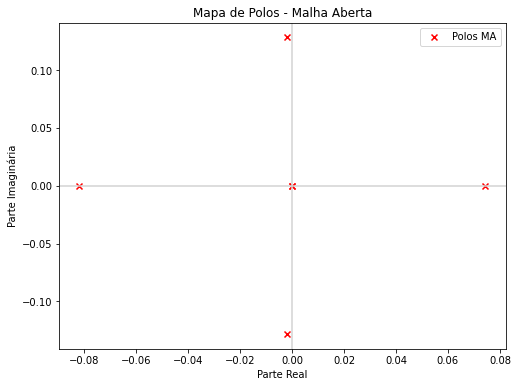

In [650]:
fig, ax = plt.subplots(figsize=(8,6))

# Polos: como 'x'
ax.scatter(poles_MA.real, poles_MA.imag, marker='x', color='red', label='Polos MA')


ax.set_xlabel('Parte Real')
ax.set_ylabel('Parte Imaginária')
ax.set_title('Mapa de Polos - Malha Aberta')
ax.grid(False)
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.legend()
plt.show()

### Resposta em frequência

/Users/mariasantos/Library/Python/3.10/lib/python/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


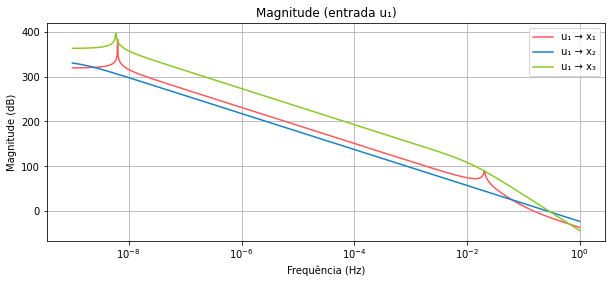

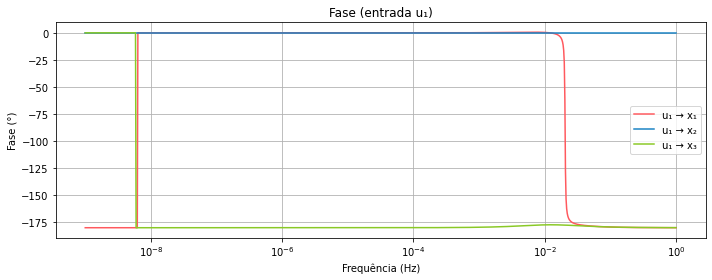

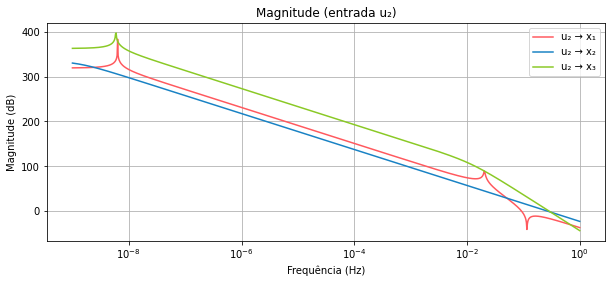

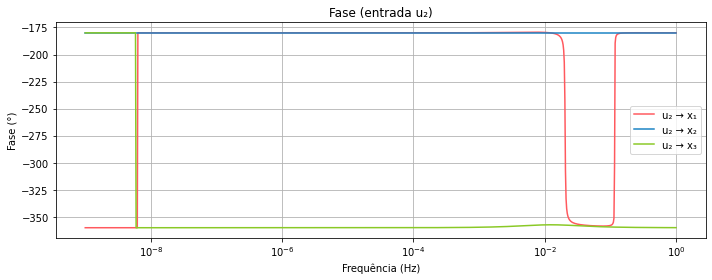

In [651]:
# Dicionário de saídas
saidas = [
    (0, 'x₁', cp['red']),
    (1, 'x₂', cp['blue']),
    (2, 'x₃', cp['green']),
]

# Frequência comum
omega = None  # será definida na 1ª chamada

# Função para plotar para uma entrada
def plot_bode_entrada(j, titulo_entrada):
    global omega

    fig_mag, ax_mag = plt.subplots(figsize=(10, 4))
    fig_phase, ax_phase = plt.subplots(figsize=(10, 4))

    for i, saida_label, color in saidas:
        mag, phase, omega = ct.bode_plot(G[i, j], dB=True, Hz=True, omega=omega, plot=False)
        freq = omega / (2 * np.pi)

        ax_mag.semilogx(freq, 20 * np.log10(mag), label=f'{titulo_entrada} → {saida_label}', color=color)
        ax_phase.semilogx(freq, phase * 180 / np.pi, label=f'{titulo_entrada} → {saida_label}', color=color)

    # Magnitude
    ax_mag.set_title(f'Magnitude (entrada {titulo_entrada})')
    ax_mag.set_xlabel('Frequência (Hz)')
    ax_mag.set_ylabel('Magnitude (dB)')
    ax_mag.grid(True, which='both')
    ax_mag.legend()

    # Fase
    ax_phase.set_title(f'Fase (entrada {titulo_entrada})')
    ax_phase.set_xlabel('Frequência (Hz)')
    ax_phase.set_ylabel('Fase (°)')
    ax_phase.grid(True, which='both')
    ax_phase.legend()

    plt.tight_layout()
    plt.show()

# Plot para u1 (coluna j=0) e u2 (coluna j=1)
plot_bode_entrada(0, 'u₁')
plot_bode_entrada(1, 'u₂')


## Controlabilidade e Observabilidade

In [652]:
# Matriz de controlabilidade
Q = ct.ctrb(A_num, B_num)
sp.Matrix(Q)

Matrix([
[              0.0,               0.0,    0.614906162867136,    0.614906162867136, -0.00249086645277544, -0.00249086645277544,  -0.337166520384773,    0.316969008165881, 0.00300648350700895, -0.00284277787001534,  0.00494793389902186, -0.00461655663370969],
[              0.0,               0.0,    -2.99052496798976,     2.99052496798976,                  0.0,                  0.0,                 0.0,                  0.0,                 0.0,                  0.0,                  0.0,                  0.0],
[              0.0,               0.0,                  0.0,                  0.0,  -8.1536972703105e-5,  -8.1536972703105e-5,   -11.0849826989195,     11.0849845644867,  0.0819533730828477,  -0.0819517005153663,  -0.0680272464908027,   0.0680272237711742],
[0.614906162867136, 0.614906162867136, -0.00249086645277544, -0.00249086645277544,   -0.337166520384773,    0.316969008165881, 0.00300648350700895, -0.00284277787001534, 0.00494793389902186, -0.00461655663370969, -5.5

In [653]:
print("O sistema é controlável?", sp.Matrix(Q).rank()==n)

O sistema é controlável? True


In [654]:
# Matriz de observabilidade
N = ct.obsv(A_num, C_num)
sp.Matrix(N)

Matrix([
[                 1.0,                   0.0,                  0.0,                   0.0,                   0.0,                   0.0],
[                 0.0,                   1.0,                  0.0,                   0.0,                   0.0,                   0.0],
[                 0.0,                   0.0,                  1.0,                   0.0,                   0.0,                   0.0],
[                 0.0,                   0.0,                  0.0,                   1.0,                   0.0,                   0.0],
[                 0.0,                   0.0,                  0.0,                   0.0,                   1.0,                   0.0],
[                 0.0,                   0.0,                  0.0,                   0.0,                   0.0,                   1.0],
[ -0.0164396756892878,     0.109368009889977,  5.15082868326662e-5,  -0.00405080742915508,                   0.0, -0.000144316149874433],
[                 0.0,   

In [655]:
print("O sistema é observável?", sp.Matrix(N).rank()==n)

O sistema é observável? True


## Regulador linear-quadrático (LQR)

In [656]:
omega_f = (poles_MA[0].real**2 + poles_MA[0].imag**2)**0.5

In [1340]:
# Matriz de ponderação Q - penaliza desvios dos estados
Q = np.diag([5, 10, 2, 5/(omega_f**2), 10/(omega_f**2), 2/(omega_f**2)])

# Matriz de ponderação R - penaliza esforço de controle
R = np.diag([10**3, 10**3])

# Síntese do regulador LQR
K_LQR, P_LQR, poles_LQR_MF = ct.lqr(A_num, B_num, Q, R)

# Sistema em malha fechada
A_LQR_MF = A_num - B_num @ K_LQR
heli_LQR_MF = ct.ss(A_LQR_MF, E_num,-K_LQR, sp.zeros(K_LQR.shape[0],E_num.shape[1]))
G_LQR_MF = ct.ss2tf(heli_LQR_MF)

In [1341]:
display(Latex(f'$Q = {sp.latex(sp.Matrix(Q))}$'))
display(Latex(f'$R = {sp.latex(sp.Matrix(R))}$'))
display(Latex(f'$K = {sp.latex(sp.Matrix(K_LQR))}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Comparação de Polos

In [1342]:
poles_LQR_MF = ct.poles(heli_LQR_MF)

# Garantir mesmo tamanho com preenchimento de NaN
max_poles = max(len(poles_MA), len(poles_LQR_MF))

# Criar DataFrame
df_poles = pd.DataFrame({
    'Polos MA': np.pad(poles_MA, (0, max_poles - len(poles_MA)), constant_values=np.nan),
    'Polos MF': np.pad(poles_LQR_MF, (0, max_poles - len(poles_LQR_MF)), constant_values=np.nan)
})

# Exibir tabelas
display(df_poles)

,Polos MA,Polos MF
0,-0.002025+0.128201j,-3.332683+0.000000j
1,-0.002025-0.128201j,-0.873842+0.937474j
2,-0.081771+0.000000j,-0.873842-0.937474j
3,0.074381+0.000000j,-0.416435+0.000000j
4,0.000000+0.000000j,-0.152682+0.000000j
5,0.000000+0.000000j,-0.128217+0.000000j


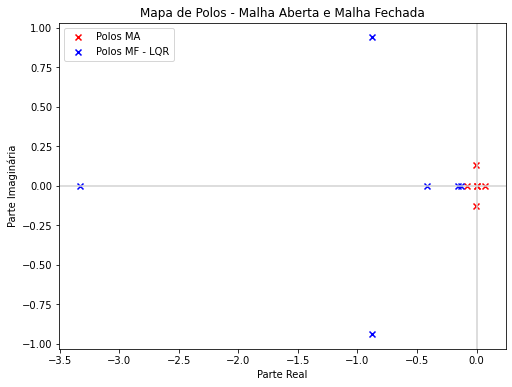

In [1343]:
fig, ax = plt.subplots(figsize=(8,6))

# Polos: como 'x'
ax.scatter(poles_MA.real, poles_MA.imag, marker='x', color='red', label='Polos MA')
ax.scatter(poles_LQR_MF.real, poles_LQR_MF.imag, marker='x', color='blue', label='Polos MF - LQR')


ax.set_xlabel('Parte Real')
ax.set_ylabel('Parte Imaginária')
ax.set_title('Mapa de Polos - Malha Aberta e Malha Fechada')
ax.grid(False)
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.legend()
plt.show()

### Resposta em frequência

/Users/mariasantos/Library/Python/3.10/lib/python/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


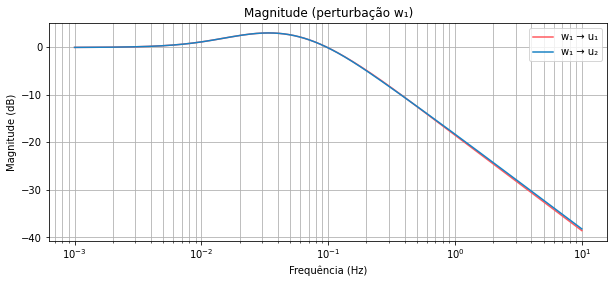

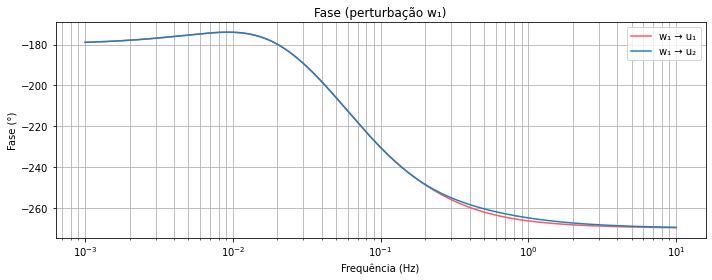

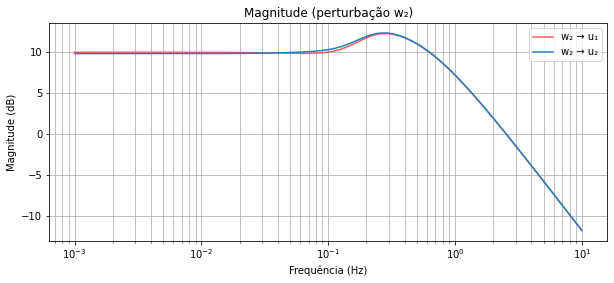

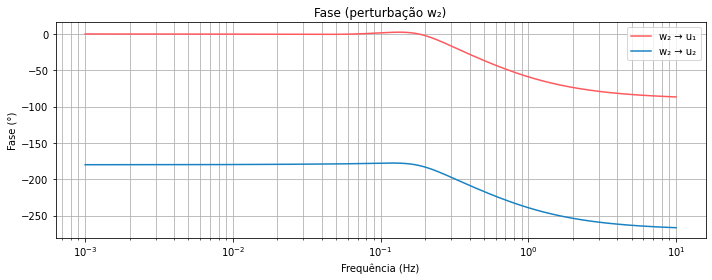

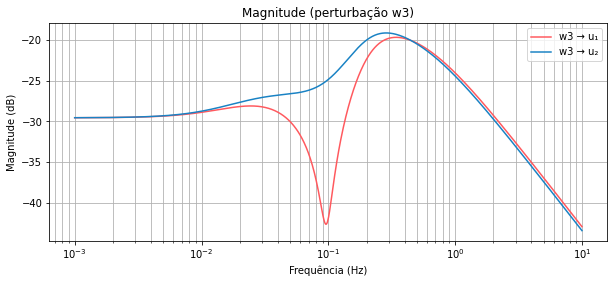

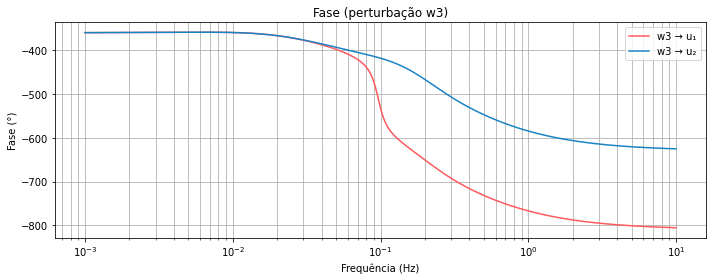

In [1344]:
# Dicionário de saídas
saidas = [
    (0, 'u₁', cp['red']),
    (1, 'u₂', cp['blue']),
]

# Frequência comum
omega = None  # será definida na 1ª chamada

# Função para plotar para uma entrada
def plot_bode_entrada(j, titulo_entrada):
    global omega

    fig_mag, ax_mag = plt.subplots(figsize=(10, 4))
    fig_phase, ax_phase = plt.subplots(figsize=(10, 4))

    for i, saida_label, color in saidas:
        mag, phase, omega = ct.bode_plot(G_LQR_MF[i, j], dB=True, Hz=True, omega=omega, plot=False)
        freq = omega / (2 * np.pi)

        ax_mag.semilogx(freq, 20 * np.log10(mag), label=f'{titulo_entrada} → {saida_label}', color=color)
        ax_phase.semilogx(freq, phase * 180 / np.pi, label=f'{titulo_entrada} → {saida_label}', color=color)

    # Magnitude
    ax_mag.set_title(f'Magnitude (perturbação {titulo_entrada})')
    ax_mag.set_xlabel('Frequência (Hz)')
    ax_mag.set_ylabel('Magnitude (dB)')
    ax_mag.grid(True, which='both')
    ax_mag.legend()

    # Fase
    ax_phase.set_title(f'Fase (perturbação {titulo_entrada})')
    ax_phase.set_xlabel('Frequência (Hz)')
    ax_phase.set_ylabel('Fase (°)')
    ax_phase.grid(True, which='both')
    ax_phase.legend()

    plt.tight_layout()
    plt.show()

# Plot para u1 (coluna j=0) e u2 (coluna j=1)
plot_bode_entrada(0, 'w₁')
plot_bode_entrada(1, 'w₂')
plot_bode_entrada(2, 'w3')

### Simulação de resposta livre do sistema controlado

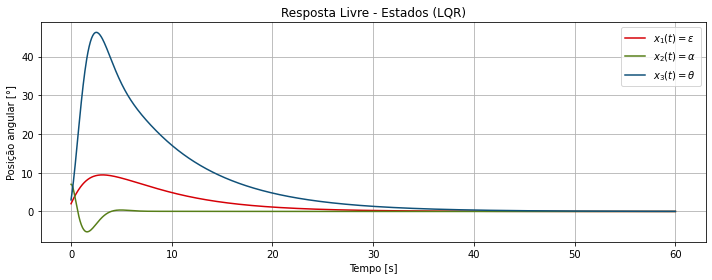

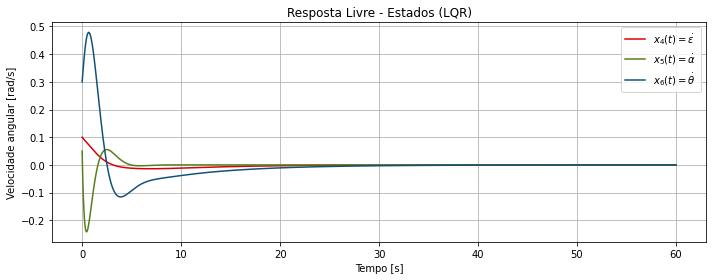

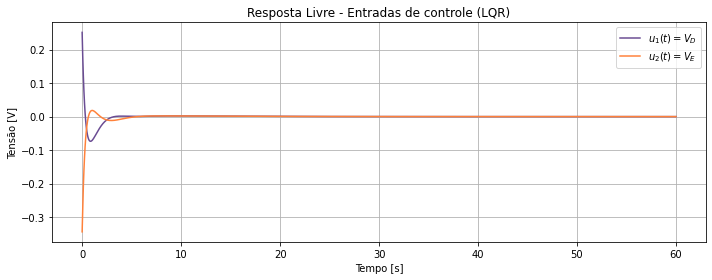

In [1345]:
ts = np.linspace(0, 60, 1001)
w = np.zeros((E_num.shape[1], len(ts)))
x0 = [2*np.pi/180, 7*np.pi/180, 3*np.pi/180, 0.1, 0.05, 0.3]
t_livre, y_livre, x_livre = ct.forced_response(heli_LQR_MF, T=ts, X0=x0, return_x=True)

plt.figure(figsize=(10, 4))
for i in range(n-m):
    cor = cp[['dred', 'dgreen', 'dblue'][i]]
    plt.plot(t_livre, x_livre[i, :]*(180/np.pi), label=f"$x_{i+1}(t)=$" + vestados[i], color = cor)
plt.title(f"Resposta Livre - Estados (LQR)")
plt.xlabel("Tempo [s]")
plt.ylabel("Posição angular [°]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(n-m, n):
    cor = cp[['dred', 'dgreen', 'dblue'][i-n+m]]
    plt.plot(t_livre, x_livre[i, :], label=f"$x_{i+1}(t)=$"+ vestados[i], color = cor)
plt.title(f"Resposta Livre - Estados (LQR)")
plt.xlabel("Tempo [s]")
plt.ylabel("Velocidade angular [rad/s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(y_livre.shape[0]):
    cor = cp[['purple', 'orange'][i]]
    plt.plot(t_livre, y_livre[i, :], label=f"$u_{i+1}(t)=$"+ ventrada[i], color = cor)
plt.title(f"Resposta Livre - Entradas de controle (LQR)")
plt.xlabel("Tempo [s]")
plt.ylabel("Tensão [V]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Simulação de resposta a perturbação de impulso em sistema controlado

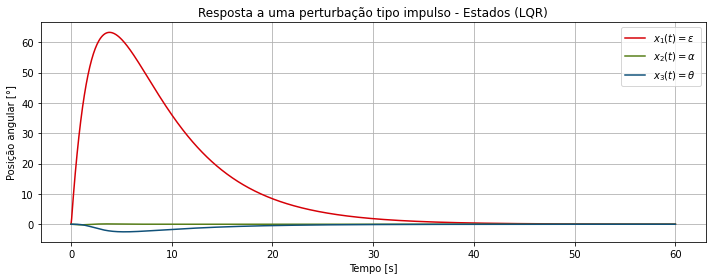

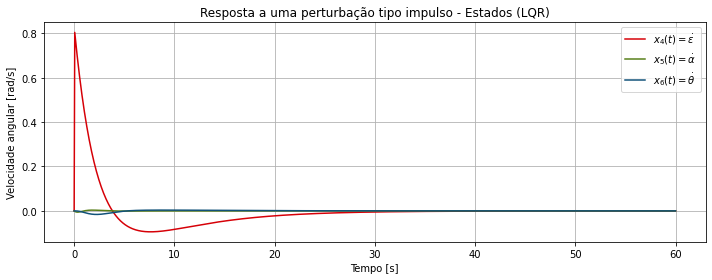

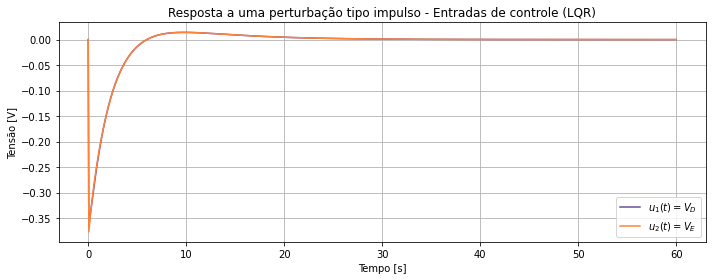

In [1346]:
ts = np.linspace(0, 60, 1001)
x0 = np.zeros(6)

w_impulse = np.zeros((E_num.shape[1], len(ts)))
w_impulse[0, 0] = 1 / (ts[1] - ts[0])  # impulso aproximado como valor alto no primeiro passo

# Simulação com perturbação
t_imp, y_imp, x_imp = ct.forced_response(heli_LQR_MF, T=ts, U=w_impulse, X0=x0, return_x=True)

# Plot dos estados
plt.figure(figsize=(10, 4))
for i in range(n-m):
    cor = cp[['dred', 'dgreen', 'dblue'][i]]
    plt.plot(t_imp, x_imp[i, :]*(180/np.pi), label=f"$x_{i+1}(t)=$" + vestados[i], color = cor)
plt.title("Resposta a uma perturbação tipo impulso - Estados (LQR)")
plt.xlabel("Tempo [s]")
plt.ylabel("Posição angular [°]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(n-m,n):
    cor = cp[['dred', 'dgreen', 'dblue'][i-n+m]]
    plt.plot(t_imp, x_imp[i, :], label=f"$x_{i+1}(t)=$" + vestados[i], color = cor)
plt.title("Resposta a uma perturbação tipo impulso - Estados (LQR)")
plt.xlabel("Tempo [s]")
plt.ylabel("Velocidade angular [rad/s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot das entradas de controle
plt.figure(figsize=(10, 4))
for i in range(y_imp.shape[0]):
    cor = cp[['purple', 'orange'][i]]
    plt.plot(t_imp, y_imp[i, :], label=f"$u_{i+1}(t)=$" + ventrada[i], color = cor)
plt.title("Resposta a uma perturbação tipo impulso - Entradas de controle (LQR)")
plt.xlabel("Tempo [s]")
plt.ylabel("Tensão [V]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Regulador por alocação de polos

Os polos serão alocados em:
* $s_1 = - 0.8$,
* $s_2 = - 0.13$, ($s_6$ do LQR)
* $s_3 = - 0.3 + 0.2j$,
* $s_4 = - 0.3 - 0.2j$
* $s_5 = - 0.1 + 0.12j$, ($s_4$ do LQR)
* $s_6 = - 0.1 - 0.12j$. ($s_5$ do LQR)

In [1347]:
poles_aloc_MF = [-0.8, -0.3+0.2j, -0.3-0.2j, poles_LQR_MF[3], poles_LQR_MF[4], poles_LQR_MF[5]]

In [1348]:
# Síntese do regulador por alocação de polos
K_aloc = place_poles(A_num, B_num, poles_aloc_MF).gain_matrix

# Sistema em malha fechada
A_aloc_MF = A_num - B_num @ K_aloc
heli_aloc_MF = ct.ss(A_aloc_MF, E_num,-K_aloc, sp.zeros(K_aloc.shape[0],E_num.shape[1]))
G_aloc_MF = ct.ss2tf(heli_aloc_MF)

/Users/mariasantos/Library/Python/3.10/lib/python/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/mariasantos/Library/Python/3.10/lib/python/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [1349]:
display(Latex(f'$K = {sp.latex(sp.Matrix(K_aloc))}$'))

<IPython.core.display.Latex object>

### Comparação de Polos

In [1350]:
poles_aloc_MF = ct.poles(heli_aloc_MF)

# Garantir mesmo tamanho com preenchimento de NaN
max_poles = max(len(poles_MA), len(poles_aloc_MF))

# Criar DataFrame
df_poles = pd.DataFrame({
    'Polos MA': np.pad(poles_MA, (0, max_poles - len(poles_MA)), constant_values=np.nan),
    'Polos MF': np.pad(poles_aloc_MF, (0, max_poles - len(poles_aloc_MF)), constant_values=np.nan)
})

# Exibir tabelas
display(df_poles)

,Polos MA,Polos MF
0,-0.002025+0.128201j,-0.800000+0.000000j
1,-0.002025-0.128201j,-0.416435+0.000000j
2,-0.081771+0.000000j,-0.300000+0.200000j
3,0.074381+0.000000j,-0.300000-0.200000j
4,0.000000+0.000000j,-0.152682+0.000000j
5,0.000000+0.000000j,-0.128217+0.000000j


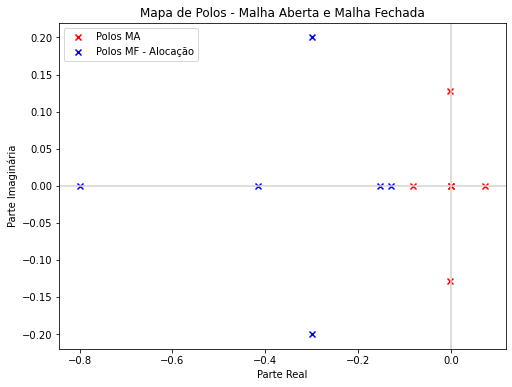

In [1351]:
fig, ax = plt.subplots(figsize=(8,6))

# Polos: como 'x'
ax.scatter(poles_MA.real, poles_MA.imag, marker='x', color='red', label='Polos MA')
ax.scatter(poles_aloc_MF.real, poles_aloc_MF.imag, marker='x', color='blue', label='Polos MF - Alocação')


ax.set_xlabel('Parte Real')
ax.set_ylabel('Parte Imaginária')
ax.set_title('Mapa de Polos - Malha Aberta e Malha Fechada')
ax.grid(False)
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.legend()
plt.show()

### Resposta em frequência

/Users/mariasantos/Library/Python/3.10/lib/python/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


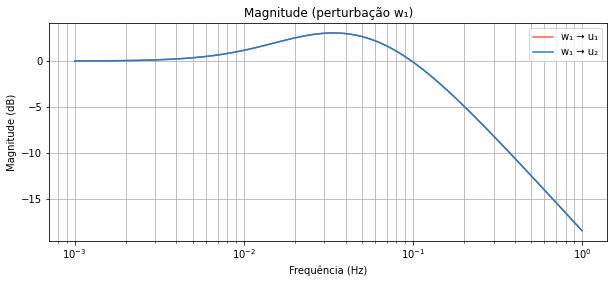

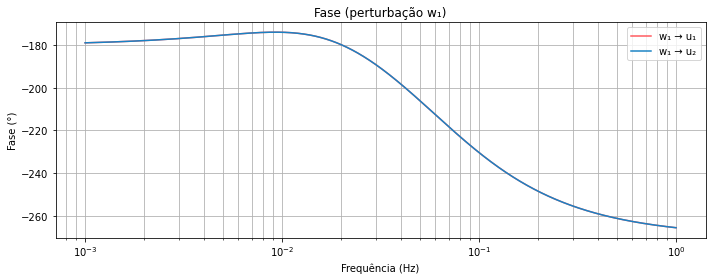

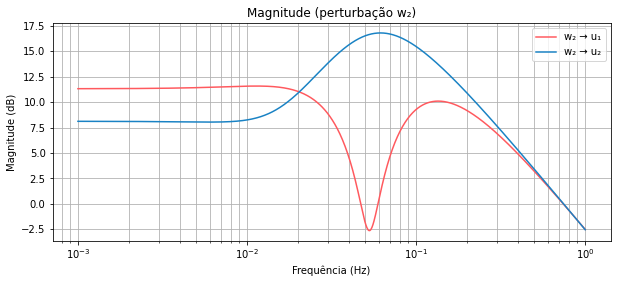

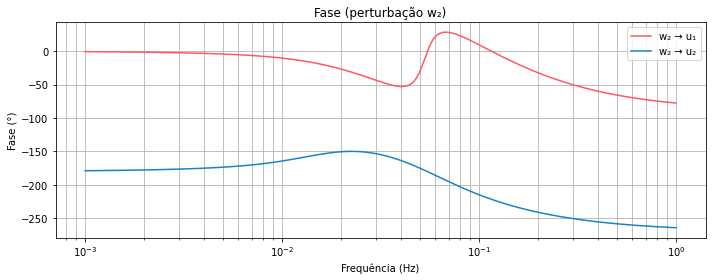

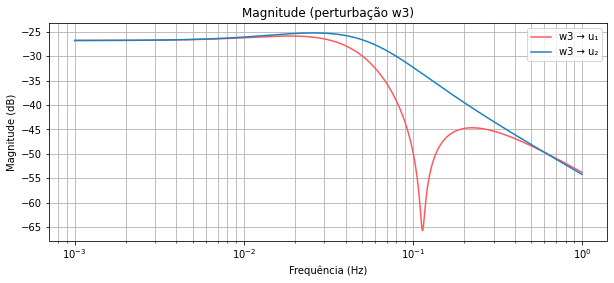

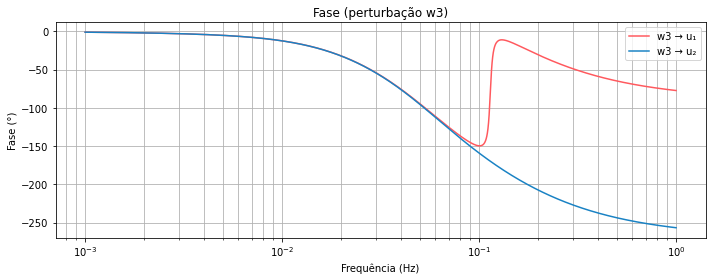

In [1352]:
# Dicionário de saídas
saidas = [
    (0, 'u₁', cp['red']),
    (1, 'u₂', cp['blue']),
]

# Frequência comum
omega = None  # será definida na 1ª chamada

# Função para plotar para uma entrada
def plot_bode_entrada(j, titulo_entrada):
    global omega

    fig_mag, ax_mag = plt.subplots(figsize=(10, 4))
    fig_phase, ax_phase = plt.subplots(figsize=(10, 4))

    for i, saida_label, color in saidas:
        mag, phase, omega = ct.bode_plot(G_aloc_MF[i, j], dB=True, Hz=True, omega=omega, plot=False)
        freq = omega / (2 * np.pi)

        ax_mag.semilogx(freq, 20 * np.log10(mag), label=f'{titulo_entrada} → {saida_label}', color=color)
        ax_phase.semilogx(freq, phase * 180 / np.pi, label=f'{titulo_entrada} → {saida_label}', color=color)

    # Magnitude
    ax_mag.set_title(f'Magnitude (perturbação {titulo_entrada})')
    ax_mag.set_xlabel('Frequência (Hz)')
    ax_mag.set_ylabel('Magnitude (dB)')
    ax_mag.grid(True, which='both')
    ax_mag.legend()

    # Fase
    ax_phase.set_title(f'Fase (perturbação {titulo_entrada})')
    ax_phase.set_xlabel('Frequência (Hz)')
    ax_phase.set_ylabel('Fase (°)')
    ax_phase.grid(True, which='both')
    ax_phase.legend()

    plt.tight_layout()
    plt.show()

# Plot para u1 (coluna j=0) e u2 (coluna j=1)
plot_bode_entrada(0, 'w₁')
plot_bode_entrada(1, 'w₂')
plot_bode_entrada(2, 'w3')

### Simulação de resposta livre do sistema controlado

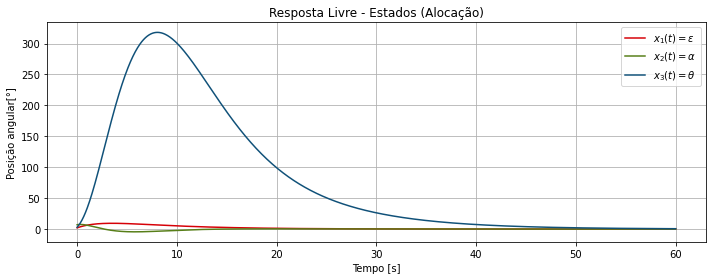

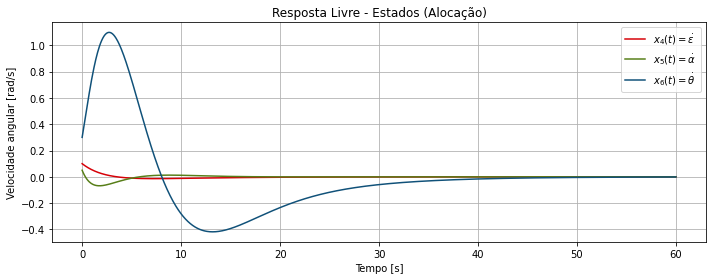

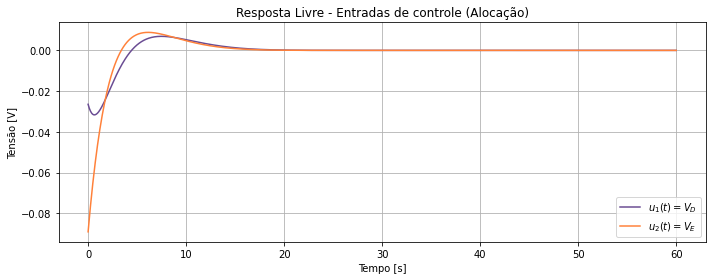

In [1353]:
ts = np.linspace(0, 60, 1001)
w = np.zeros((E_num.shape[1], len(ts)))
x0 = [2*np.pi/180, 7*np.pi/180, 3*np.pi/180, 0.1, 0.05, 0.3]
t_livre, y_livre, x_livre = ct.forced_response(heli_aloc_MF, T=ts, X0=x0, return_x=True)

plt.figure(figsize=(10, 4))
for i in range(n-m):
    cor = cp[['dred', 'dgreen', 'dblue'][i]]
    plt.plot(t_livre, x_livre[i, :]*(180/np.pi), label=f"$x_{i+1}(t)=$" + vestados[i], color = cor)
plt.title(f"Resposta Livre - Estados (Alocação)")
plt.xlabel("Tempo [s]")
plt.ylabel("Posição angular[°]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(n-m, n):
    cor = cp[['dred', 'dgreen', 'dblue'][i-n+m]]
    plt.plot(t_livre, x_livre[i, :], label=f"$x_{i+1}(t)=$" + vestados[i], color = cor)
plt.title(f"Resposta Livre - Estados (Alocação)")
plt.xlabel("Tempo [s]")
plt.ylabel("Velocidade angular [rad/s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(y_livre.shape[0]):
    cor = cp[['purple', 'orange'][i]]
    plt.plot(t_livre, y_livre[i, :], label=f"$u_{i+1}(t) = $" + ventrada[i], color = cor)
plt.title(f"Resposta Livre - Entradas de controle (Alocação)")
plt.xlabel("Tempo [s]")
plt.ylabel("Tensão [V]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Simulação de resposta a perturbação de impulso em sistema controlado

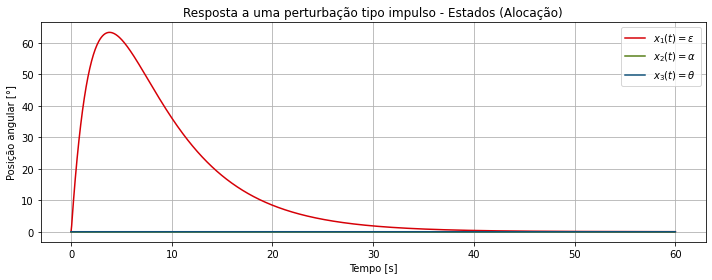

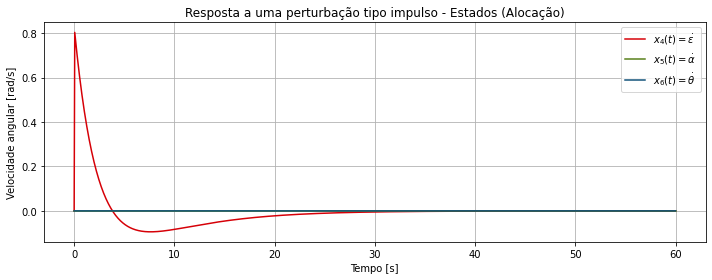

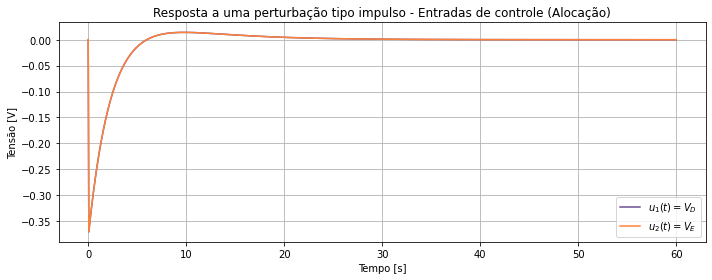

In [1484]:
ts = np.linspace(0, 60, 1001)
x0 = np.zeros(6)

w_impulse = np.zeros((E_num.shape[1], len(ts)))
w_impulse[0, 0] = 1 / (ts[1] - ts[0])  # impulso aproximado como valor alto no primeiro passo

# Simulação com perturbação
t_imp, y_imp, x_imp = ct.forced_response(heli_aloc_MF, T=ts, U=w_impulse, X0=x0, return_x=True)

plt.figure(figsize=(10, 4))
for i in range(n-m):
    cor = cp[['dred', 'dgreen', 'dblue'][i]]
    plt.plot(t_imp, x_imp[i, :]*(180/np.pi), label=f"$x_{i+1}(t)=$" + vestados[i], color = cor)
plt.title("Resposta a uma perturbação tipo impulso - Estados (Alocação)")
plt.xlabel("Tempo [s]")
plt.ylabel("Posição angular [°]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(n-m, n):
    cor = cp[['dred', 'dgreen', 'dblue'][i-n+m]]
    plt.plot(t_imp, x_imp[i, :], label=f"$x_{i+1}(t)=$" + vestados[i], color = cor)
plt.title("Resposta a uma perturbação tipo impulso - Estados (Alocação)")
plt.xlabel("Tempo [s]")
plt.ylabel("Velocidade angular [rad/s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(r):
    cor = cp[['purple', 'orange'][i]]
    plt.plot(t_imp, y_imp[i, :], label=f"$u_{i+1}(t)=$" + ventrada[i], color = cor)
plt.title("Resposta a uma perturbação tipo impulso - Entradas de controle (Alocação)")
plt.xlabel("Tempo [s]")
plt.ylabel("Tensão [V]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Observador de Estados de Ordem Reduzida

Como o controlador LQR (por alocação de polos) é mais adequado

In [1355]:
K = K_LQR
poles_cont = poles_LQR_MF
A_cont = A_LQR_MF

In [1356]:
np.linalg.matrix_rank(C_num) == m

True

In [1357]:
# Matrizes auxiliares da transformação de variáveis
V = la.null_space(C_num, rcond=1e-10).T
T = np.block([[C_num], [V]])
Ti = la.inv(T)
M = Ti[:, 0:m]
N = Ti[:, m:]
A11 = C_num @ A_num @ M
A12 = C_num @ A_num @ N
A21 = V @ A_num @ M
A22 = V @ A_num @ N
B1 = C_num @ B_num
B2 = V @ B_num

In [1358]:
# Teste de observabilidade
np.linalg.matrix_rank(ct.obsv(A22, A12)) == A22.shape[0]

True

Os polos desejados pelo observador são:
* $s_1 = - 8 - 2.5j$,
* $s_2 = - 8 + 2.5j$ 
* $s_3 = - 8.5$.

In [1464]:
# Polos do observador
poles_obs = [-8-2.5j, -8+2.5j, -8.5]

# Alocação de polos do observador
J = (place_poles(A22.T, A12.T, poles_obs).gain_matrix).T

# Matrizes F, G, H e S

F = A22 - J @ A12
G_obs = A21  - J @ A11 + F @ J
H = B2 - J @ B1
S = M + N @ J

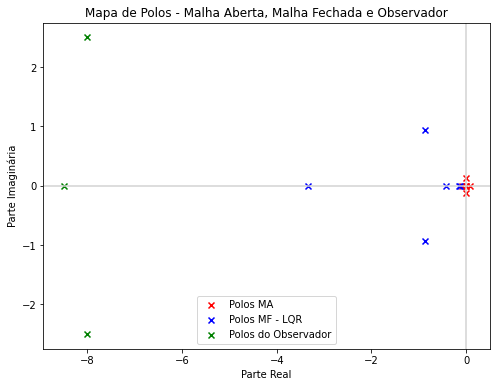

In [1465]:
fig, ax = plt.subplots(figsize=(8,6))

# Polos: como 'x'
ax.scatter(poles_MA.real, poles_MA.imag, marker='x', color='red', label='Polos MA')
ax.scatter(poles_LQR_MF.real, poles_LQR_MF.imag, marker='x', color='blue', label='Polos MF - LQR')
ax.scatter(np.array(poles_obs).real, np.array(poles_obs).imag, marker='x', color='green', label='Polos do Observador')



ax.set_xlabel('Parte Real')
ax.set_ylabel('Parte Imaginária')
ax.set_title('Mapa de Polos - Malha Aberta, Malha Fechada e Observador')
ax.grid(False)
ax.axhline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.axvline(0, color='lightgrey', linestyle='-', linewidth=1.5)
ax.legend()
plt.show()

Colocando o sistema na forma de espaço de estados:

\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}t}
    \begin{bmatrix}
        x(t) \\ z(t)
    \end{bmatrix}
    = 
    \begin{bmatrix}
        A & 0 \\ GC & F
    \end{bmatrix}
    \begin{bmatrix}
        x(t) \\ z(t)
    \end{bmatrix}
    +
    \begin{bmatrix}
        B \\ H
    \end{bmatrix}
    u(t)
\end{align*}

In [1466]:
A_obs = np.block([[A_num, np.zeros((n, n-m))], [G_obs @ C_num, F]])
B_obs = np.block([[B_num], [H]])
E_obs = np.block([[E_num], [np.zeros((n-m, l))]])
C_obs = np.block([[C_num, np.zeros((m, n-m))]])

\begin{align*}
    \Rightarrow\frac{\mathrm{d}}{\mathrm{d}t}
    \begin{bmatrix}
        x(t) \\ z(t)
    \end{bmatrix}
    = 
   A_{obs}
    \begin{bmatrix}
        x(t) \\ z(t)
    \end{bmatrix}
    +
    B_{obs}
    u(t)
    + E_{obs} w(t)
\end{align*}

\begin{align*}
    y(t)=C_{obs} \begin{bmatrix}
        x(t) \\ z(t)
    \end{bmatrix}
\end{align*}

In [1467]:
display(Latex(f'$A_{{obs}} = {sp.latex(sp.Matrix(A_obs))}$'))
display(Latex(f'$B_{{obs}} = {sp.latex(sp.Matrix(B_obs))}$'))
display(Latex(f'$E_{{obs}} = {sp.latex(sp.Matrix(E_obs))}$'))
display(Latex(f'$C_{{obs}} = {sp.latex(sp.Matrix(C_obs))}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Simulação de teste

Adotando a lei de controle:
\begin{align*}
    u(t) = - K \hat x(t) = - K \begin{bmatrix}
        SC & N
    \end{bmatrix}
    \begin{bmatrix}
        x(t) \\ z(t)
    \end{bmatrix}
\end{align*}
pode-se estabelecer a dinâmica do sistema aumentado em malha-fechada:

In [1468]:
# Sistema com observador
K_obs_cont = K @ np.block([S @ C_num, N])
A_obs_cont = A_obs - B_obs @ K_obs_cont
 
heli_obs_cont = ct.ss(A_obs_cont, E_obs, -K_obs_cont, sp.zeros(2,3)) # mapeia perturbação w(t) para entrada u(t)
G_obs_cont = ct.ss2tf(heli_obs_cont)

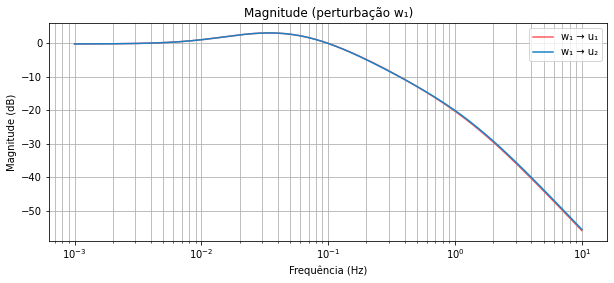

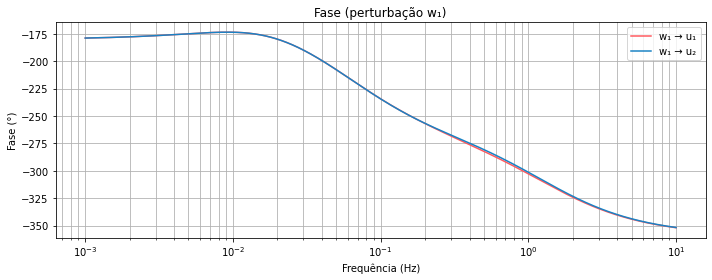

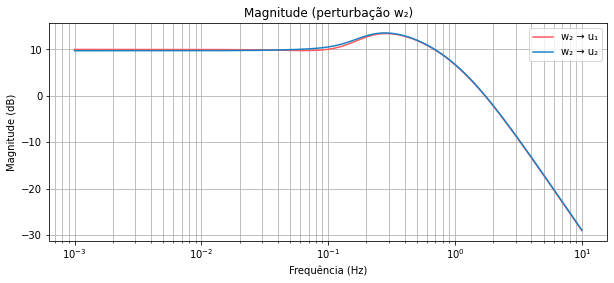

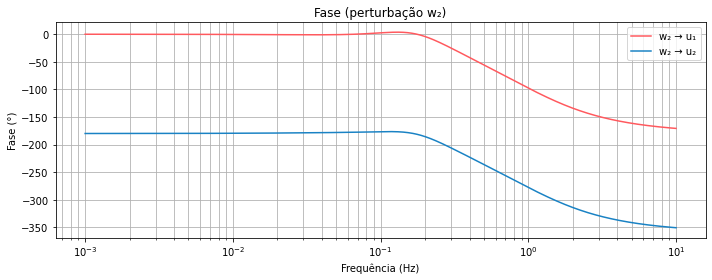

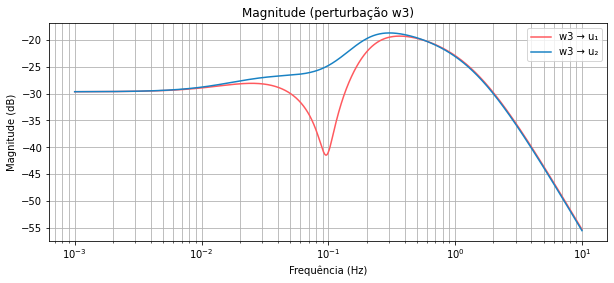

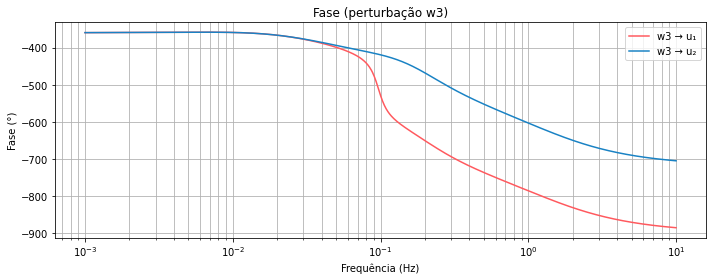

In [1469]:
# Dicionário de saídas
saidas = [
    (0, 'u₁', cp['red']),
    (1, 'u₂', cp['blue']),
]

# Frequência comum
omega = None  # será definida na 1ª chamada

# Função para plotar para uma entrada
def plot_bode_entrada(j, titulo_entrada):
    global omega

    fig_mag, ax_mag = plt.subplots(figsize=(10, 4))
    fig_phase, ax_phase = plt.subplots(figsize=(10, 4))

    for i, saida_label, color in saidas:
        mag, phase, omega = ct.bode_plot(G_obs_cont[i, j], dB=True, Hz=True, omega=omega, plot=False)
        freq = omega / (2 * np.pi)

        ax_mag.semilogx(freq, 20 * np.log10(mag), label=f'{titulo_entrada} → {saida_label}', color=color)
        ax_phase.semilogx(freq, phase * 180 / np.pi, label=f'{titulo_entrada} → {saida_label}', color=color)

    # Magnitude
    ax_mag.set_title(f'Magnitude (perturbação {titulo_entrada})')
    ax_mag.set_xlabel('Frequência (Hz)')
    ax_mag.set_ylabel('Magnitude (dB)')
    ax_mag.grid(True, which='both')
    ax_mag.legend()

    # Fase
    ax_phase.set_title(f'Fase (perturbação {titulo_entrada})')
    ax_phase.set_xlabel('Frequência (Hz)')
    ax_phase.set_ylabel('Fase (°)')
    ax_phase.grid(True, which='both')
    ax_phase.legend()

    plt.tight_layout()
    plt.show()

# Plot para u1 (coluna j=0) e u2 (coluna j=1)
plot_bode_entrada(0, 'w₁')
plot_bode_entrada(1, 'w₂')
plot_bode_entrada(2, 'w3')

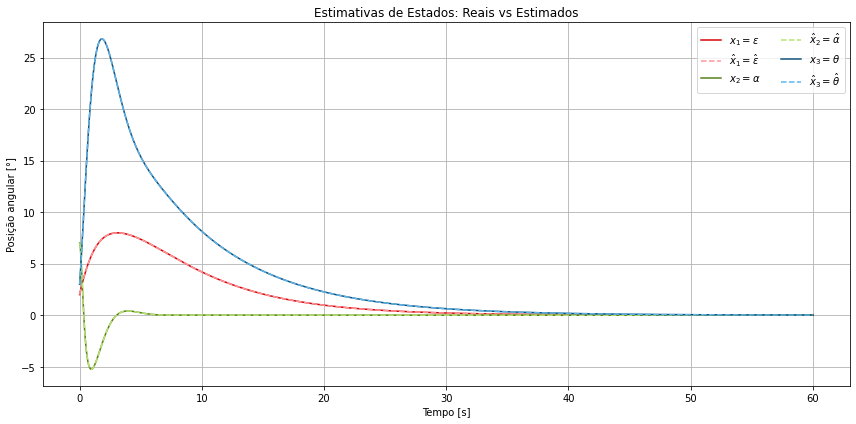

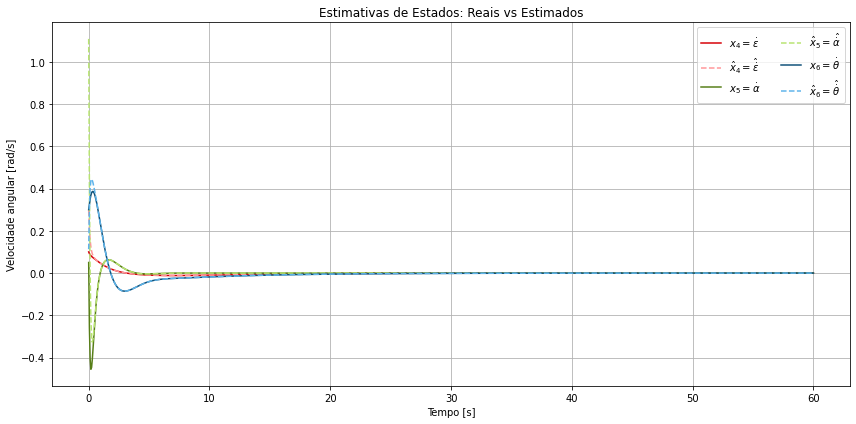

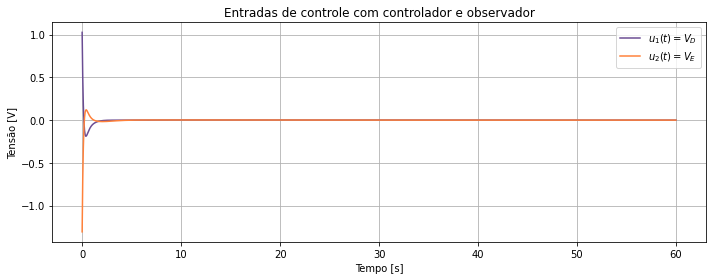

In [ ]:
# Condições iniciais coerentes com ângulos e velocidades pequenas
x0_real = np.array([2*np.pi/180, 7*np.pi/180, 3*np.pi/180, 0.1, 0.05, 0.3])  # rad, rad/s
z0 = np.zeros(n - m)  # z(t=0) = 0

# Estado inicial total [x(0); z(0)]
x0z0 = np.concatenate([x0_real, z0])
# Tempo e entrada
t = np.linspace(0, 60, 1000)
w = np.zeros((3, len(t)))

# Simulação
t_obs_cont, u_obs_cont, x_obs_cont = ct.forced_response(heli_obs_cont, T=t, U=w, X0=x0z0, return_x=True)
x_hat_t = np.array(S @ C_num @ x_obs_cont[0:n, :] + N @ x_obs_cont[n:, :]).astype(np.float64)  # estimativa dos estados reais

plt.figure(figsize=(12, 6))

for i in range(n-m): 
    cor1 = cp[['dred', 'dgreen', 'dblue'][i]]
    cor2 = cp[['lred', 'lgreen', 'lblue'][i]]
    plt.plot(t_obs_cont, x_obs_cont[i, :]*(180/np.pi), label=f'$x_{{{i+1}}} = $' + vestados[i], color=cor1)
    plt.plot(t_obs_cont, x_hat_t[i, :].flatten()*(180/np.pi), '--', label=f'$\\hat{{x}}_{{{i+1}}} = $' + vestadosE[i], color=cor2)

plt.xlabel('Tempo [s]')
plt.ylabel('Posição angular [°]')
plt.title('Estimativas de Estados: Reais vs Estimados')
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

for i in range(n-m, n): 
    cor1 = cp[['dred', 'dgreen', 'dblue'][i-n+m]]
    cor2 = cp[['lred', 'lgreen', 'lblue'][i-n+m]]
    plt.plot(t_obs_cont, x_obs_cont[i, :], label=f'$x_{{{i+1}}} = $' + vestados[i], color=cor1)
    plt.plot(t_obs_cont, x_hat_t[i, :].flatten(), '--', label=f'$\\hat{{x}}_{{{i+1}}} = $' + vestadosE[i], color=cor2)

plt.xlabel('Tempo [s]')
plt.ylabel('Velocidade angular [rad/s]')
plt.title('Estimativas de Estados: Reais vs Estimados')
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(r):
    cor = cp[['purple', 'orange'][i]]
    plt.plot(t_obs_cont, u_obs_cont[i, :], label=f"$u_{i+1}(t)=$" + ventrada[i], color = cor)
plt.title(f"Entradas de controle com controlador e observador")
plt.xlabel("Tempo [s]")
plt.ylabel("Tensão [V]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

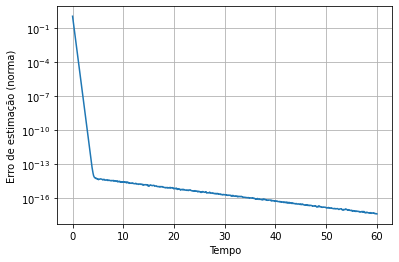

In [1471]:
erro_estimacao = np.linalg.norm(x_hat_t - x_obs_cont[0:n, :], axis=0)

import matplotlib.pyplot as plt
plt.semilogy(t_obs_cont, erro_estimacao)
plt.xlabel('Tempo')
plt.ylabel('Erro de estimação (norma)')
plt.grid()
plt.show()

## Cenários de Simulação

In [1573]:
def cenario1():
    x0 = np.array([2*np.pi/180, 5*np.pi/180, 1*np.pi/180, 0.1, 0.05, 0.3])

    def w_func(t):
        M_Px = 0
        M_Py = -0.001 * (np.heaviside(t - 12, 1) - np.heaviside(t - 18, 1)) 
        M_Pz = -0.008 * (np.heaviside(t - 16, 1) - np.heaviside(t - 23, 1)) + 0.012 * (np.heaviside(t - 35, 1) - np.heaviside(t - 38, 1))
        return np.array([M_Px, M_Py, M_Pz])
    
    def x_ref_func(t):
        ref = np.array([4*np.pi/180, 0*np.pi/180, 0*np.pi/180, 0, 0, 0])
        return ref
    return {'x0': x0, 'w_func': w_func, 'x_ref_func': x_ref_func}


In [1574]:
def cenario2():
    x0 = np.array([0, 0, 0, 0, 0, 0])

    def w_func(t):
        M_Px = 0.003 * (np.heaviside(t - 11, 1) - np.heaviside(t - 19, 1)) + 0.002 * (np.heaviside(t - 24, 1) - np.heaviside(t - 32, 1))
        M_Py = 0
        M_Pz = -0.012 * (np.heaviside(t - 20, 1) - np.heaviside(t - 26, 1))

        return np.array([M_Px, M_Py, M_Pz])

    def x_ref_func(t):
        ref = np.zeros(n)
        amplitude = 0.15
        if 0 <= t <= 10:
            ref[0] = amplitude * (t/10)
            ref[3] = amplitude *(1/10)
            return ref
        if 10 < t<= 45:
            ref[0] = amplitude
            ref[3] = 0
            return ref
        if 45 < t <= 55:
            ref[0] = amplitude * (1 - (t-45)/10)
            ref[3] = -amplitude *(1/10)
            return ref
        else:
            return ref

    return {'x0': x0, 'w_func': w_func, 'x_ref_func': x_ref_func}

## Simulações do sistema com regulador e observador

In [1575]:
def simular_cenario(cenario, T, title):
    # Tempo de simulação
    t = np.linspace(0, T, 1000)
    # Parâmetros do cenário
    x0 = cenario()['x0']
    w = np.array([cenario()['w_func'](ti) for ti in t]).T  # shape (3, len(t))

    # Condição inicial estendida [x0; z0]
    z0 = np.zeros(n - m)
    x0_ext = np.concatenate((x0, z0))

    # Simulação
    t_out, y_out, x_out = ct.forced_response(heli_obs_cont, T=t, U=w, X0=x0_ext, return_x=True)
    x_hat_t = np.array(S @ C_num @ x_out[0:n, :] + N @ x_out[n:, :]).astype(np.float64)  # estimativa dos estados reais

    plt.figure(figsize=(12, 6))
    for i in range(n-m):
        cor1 = cp[['dred', 'dgreen', 'dblue'][i]]
        cor2 = cp[['lred', 'lgreen', 'lblue'][i]]
        plt.plot(t_out, x_out[i, :]*(180/np.pi), label=f'$x_{{{i+1}}}=$' + vestados[i], color = cor1)
        plt.plot(t_out, x_hat_t[i, :].flatten()*(180/np.pi), '--', label=f'$\\hat{{x}}_{{{i+1}}}=$' + vestadosE[i], color = cor2)

    plt.xlabel('Tempo [s]')
    plt.ylabel('Posição angular [°]')
    plt.title(title + ': Observador + Controlador')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for i in range(n-m, n):
        cor1 = cp[['dred', 'dgreen', 'dblue'][i-n+m]]
        cor2 = cp[['lred', 'lgreen', 'lblue'][i-n+m]]
        plt.plot(t_out, x_out[i, :], label=f'$x_{{{i+1}}}=$' + vestados[i], color = cor1)
        plt.plot(t_out, x_hat_t[i, :].flatten(), '--', label=f'$\\hat{{x}}_{{{i+1}}}=$' + vestadosE[i], color = cor2)

    plt.xlabel('Tempo [s]')
    plt.ylabel('Velocidade angular [rad/s]')
    plt.title(title + ': Observador + Controlador')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    for i in range(r):
        plt.plot(t_out, y_out[i, :], label=f"$u_{i+1}(t)=$" + ventrada[i])
    plt.title(title + ': Entradas de controle com controlador e observador')
    plt.xlabel("Tempo [s]")
    plt.ylabel("Tensão [V]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

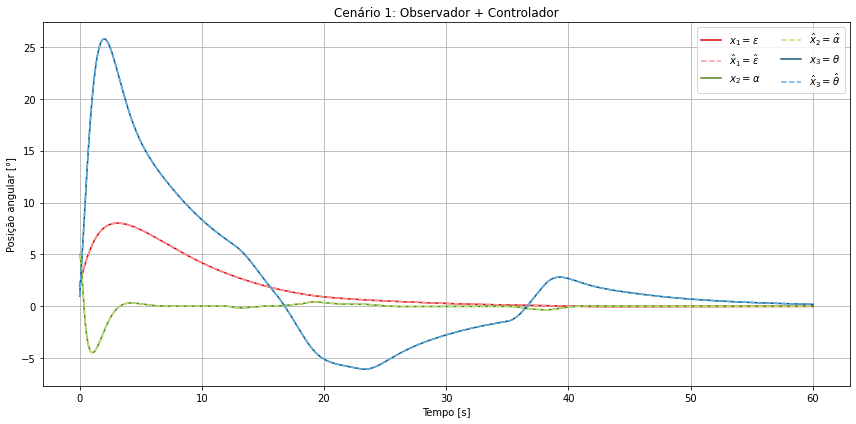

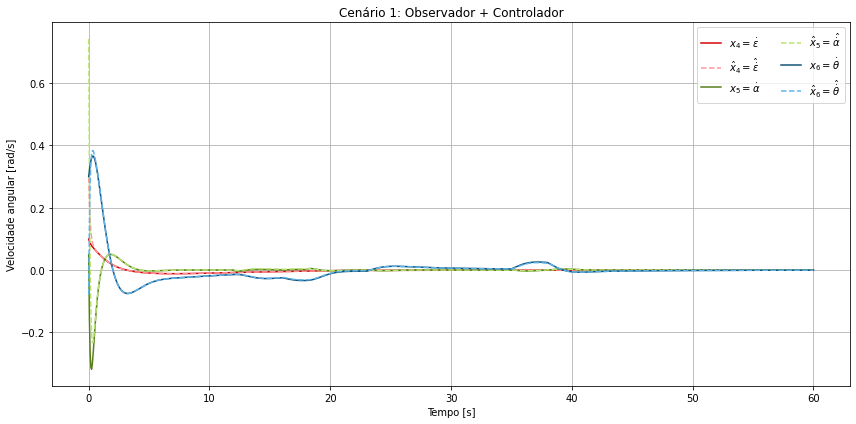

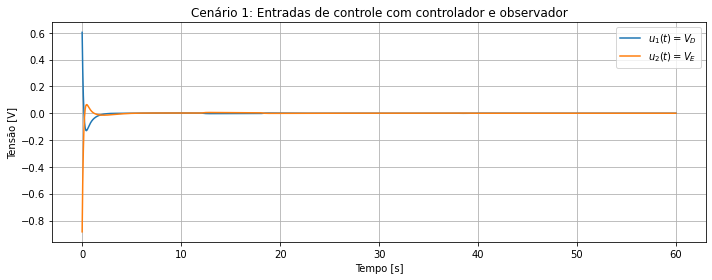

In [1576]:
simular_cenario(cenario1, T=60, title ='Cenário 1')

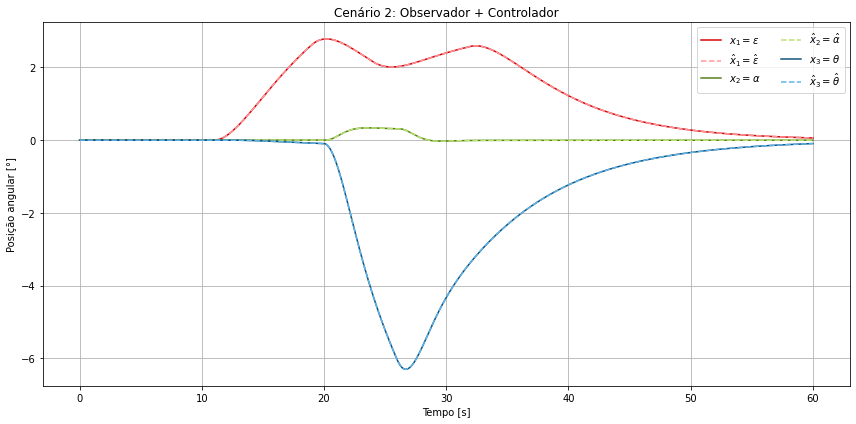

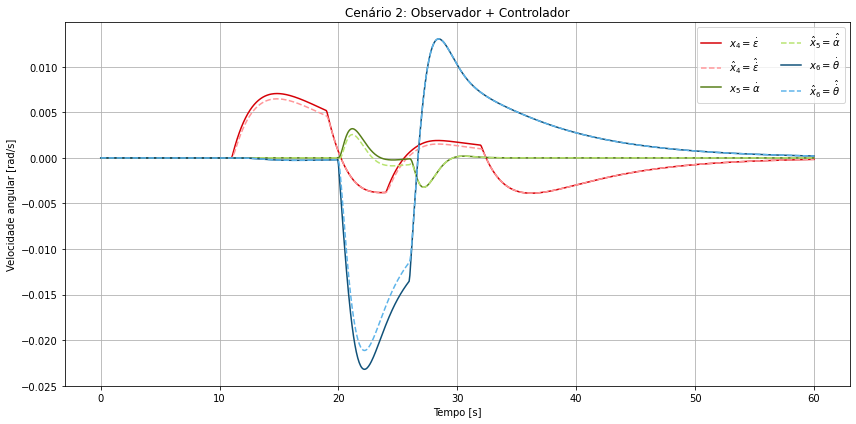

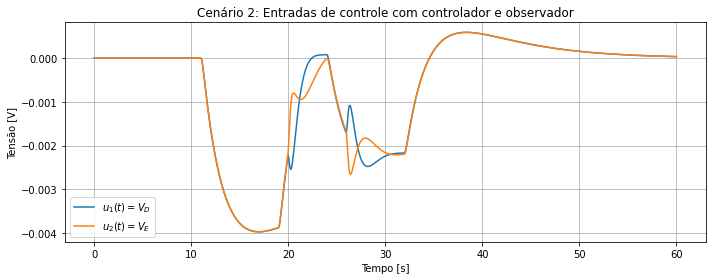

In [1577]:
simular_cenario(cenario2, T=60, title ='Cenário 2')

## Síntese de pré-alimentação

### Seguidor LQ

In [1578]:
Q_LQ = np.diag([5e1, 10e1, 2e1, 5e0, 10e0, 2e0])
R_LQ = np.diag([1e-2, 1e-2]) 


# Síntese do regulador LQR
K_LQ, P_LQ, poles_LQ = ct.lqr(A_num, B_num, Q_LQ, R_LQ)
A_LQ = A_num - B_num @ K_LQ

In [1585]:
display(Latex(f'$Q = {sp.latex(sp.Matrix(Q_LQ))}$'))
display(Latex(f'$R = {sp.latex(sp.Matrix(R_LQ))}$'))
display(Latex(f'$K = {sp.latex(sp.Matrix(K_LQ))}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Sistema com pré-alimentação

In [1579]:
# Definindo referências de rastreamento
cen = cenario2()
t = np.linspace(0, 60, 1001)
x_ref_func = cen['x_ref_func']

x_ref = np.array([x_ref_func(ti) for ti in t]).T # shape: (n, len(t))

# Custo terminal backward
η0 = P_LQ @ x_ref[:, -1].reshape(-1, 1)

# Sistema auxiliar (tempo reverso)
η_ss = ct.ss(-(A_LQ.T), -Q_LQ, np.eye(n), np.zeros_like(Q_LQ))
ts_rev, η = ct.forced_response(η_ss, T=t[::-1], U=x_ref[:, ::-1], X0=η0)
η = η[:, ::-1]  # reverter para frente no tempo

# Controle final via convolução com matriz de controle
B_aux = B_num @ np.linalg.inv(R_LQ) @ B_num.T
D_aux = np.linalg.inv(R_LQ) @ B_num.T
heli_pre = ct.ss(A_LQ, B_aux, -K_LQ, D_aux)
ts_d, u_lq, x_lq = ct.forced_response(heli_pre, T=t, U=η, return_x=True)

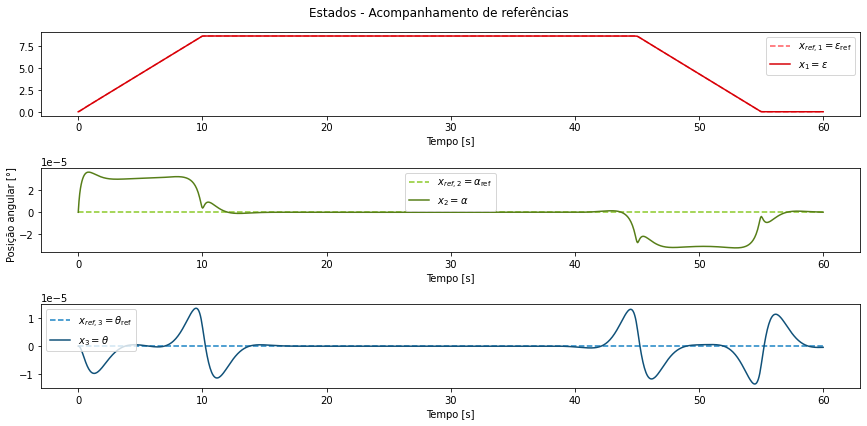

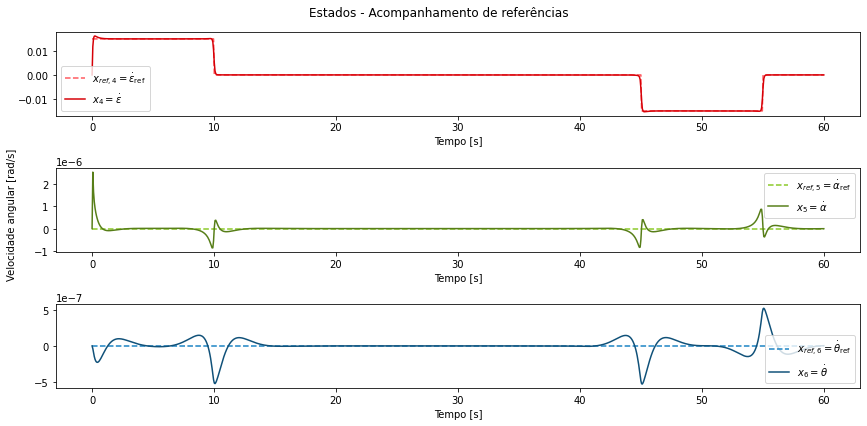

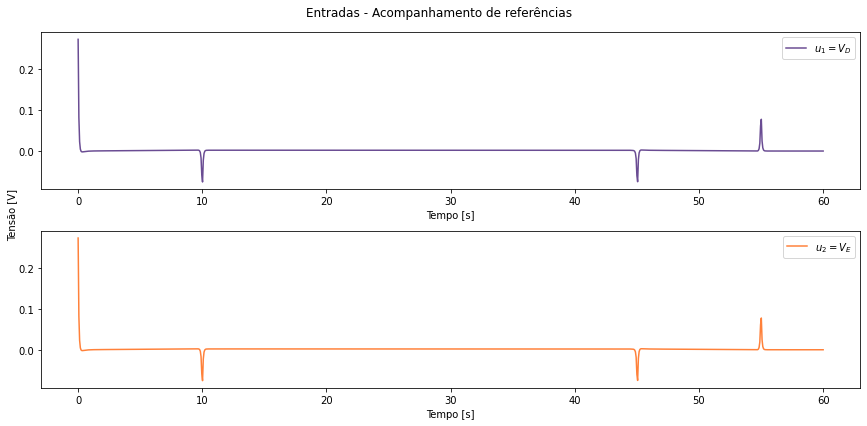

In [1580]:
fig, axs = plt.subplots(nrows=n-m, ncols=1, figsize=(12, 6))
plt.suptitle("Estados - Acompanhamento de referências")
for i in range(n-m):
    cor1 = cp[['dred', 'dgreen', 'dblue'][i]]
    cor3 = cp[['red', 'green', 'blue'][i]]
    axs[i].plot(ts, x_ref[i, :] * 180/np.pi, '--', label=f'$x_{{ref,{i+1}}}=$' + vestadosR[i], color=cor3)
    axs[i].plot(ts, x_lq[i, :] * 180/np.pi, label=f'$x_{{{i+1}}}=$' + vestados[i], color=cor1)
    axs[i].set_xlabel('Tempo [s]')
    axs[i].legend()
fig.text(0, 0.5, 'Posição angular [°]', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=n-m, ncols=1, figsize=(12, 6))
plt.suptitle("Estados - Acompanhamento de referências")
for i in range(n-m,n):
    cor1 = cp[['dred', 'dgreen', 'dblue'][i-n+m]]
    cor3 = cp[['red', 'green', 'blue'][i-n+m]]
    axs[i-n+m].plot(ts, x_ref[i, :], '--', label=f'$x_{{ref,{i+1}}}=$' + vestadosR[i], color=cor3)
    axs[i-n+m].plot(ts, x_lq[i, :], label=f'$x_{{{i+1}}}=$' + vestados[i], color=cor1)
    axs[i-n+m].set_xlabel('Tempo [s]')
    axs[i-n+m].legend()

fig.text(0, 0.5, 'Velocidade angular [rad/s]', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=r, ncols=1, figsize=(12, 6))
plt.suptitle("Entradas - Acompanhamento de referências")
for i in range(r):
    cor = cp[['purple', 'orange'][i]]
    axs[i].plot(ts, u_lq[i, :], label=f'$u_{{{i+1}}}=$' + ventrada[i], color=cor)
    axs[i].set_xlabel('Tempo [s]')
    axs[i].legend()

fig.text(0, 0.5, 'Tensão [V]', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

## Simulações em Malha Fechada

Lei de controle:
\begin{align*}
    \mathbf{u}(t) = &\mathbf{u}_{realimentacao}(t) + \mathbf{R}^{-1}\mathbf{B}^\top(\mathbf{\eta}(t)-\mathbf{P}\mathbf{x}_{ref}(t))\\
    & = -\mathbf{K}\begin{bmatrix}
    \mathbf{S}\mathbf{C}& \mathbf{N}
    \end{bmatrix}\begin{bmatrix}
        \mathbf{x}(t)\\
        \mathbf{z}(t)
    \end{bmatrix} + \mathbf{R}^{-1}\mathbf{B}^\top(\mathbf{\eta}(t)-\mathbf{P}\mathbf{x}_{ref}(t))
\end{align*}

Espaço de estados aumentado:
\begin{align*}
    \frac{d}{dt}\begin{bmatrix}
        \mathbf{x}(t)\\
        \mathbf{z}(t)\\
    \end{bmatrix}= (A_{obs}-B_{obs}K_{obs})\begin{bmatrix}
        \mathbf{x}(t)\\
        \mathbf{z}(t)\\
    \end{bmatrix} + \begin{bmatrix}
    E_{obs} & B_{obs}K_{ff}\end{bmatrix}\begin{bmatrix}
    \mathbf{w}\\ \mathbf{\eta}\\ \mathbf{x}_{ref}\end{bmatrix}
\end{align*}

Com 
\begin{align*}K_{ff} = \begin{bmatrix}
    \mathbf{R}^{-1}\mathbf{B}^\top &
    -\mathbf{R}^{-1}\mathbf{B}^\top\mathbf{P}
    \end{bmatrix}
\end{align*}

In [1581]:
Kff = np.block([
    [np.linalg.inv(R_LQ) @ B_num.T, -np.linalg.inv(R_LQ) @ B_num.T @ P_LQ]
])

E_full = np.block([
    [E_obs, B_obs @ Kff]
])

heli_full = ct.ss(A_obs_cont, E_full, -K_obs_cont, sp.zeros(K_obs_cont.shape[0], E_full.shape[1]))

In [1582]:
def simulacao_completa(cenario, T, title):
    cen = cenario()
    t = np.linspace(0, T, 1001)

    x0 = cen['x0']
    w_func = cen['w_func']
    x_ref_func = cen['x_ref_func']

    X0 = np.block([
        [x0.reshape(-1, 1)],
        [np.zeros((n - m, 1))]
    ])

    w = np.array([w_func(ti) for ti in t]).T         # shape: (l, len(t))
    x_ref = np.array([x_ref_func(ti) for ti in t]).T # shape: (n, len(t))

    # Custo terminal backward
    η0 = P_LQ @ x_ref[:, -1].reshape(-1, 1)

    # Sistema auxiliar (tempo reverso)
    η_ss = ct.ss(-A_LQ.T, -Q_LQ, np.eye(n), np.zeros_like(Q_LQ))
    ts_rev, η = ct.forced_response(η_ss, T=t[::-1], U=x_ref[:, ::-1], X0=η0)
    η = η[:, ::-1]  # reverter para frente no tempo

    # Montar entrada completa para o sistema aumentado
    U = np.vstack([w, η, x_ref])  # shape: (l + n + n, len(t))

    # Simulação do sistema aumentado
    t_full, y_full, x_full = ct.forced_response(heli_full, T=t, U=U, X0=X0, return_x=True)

    x_hat_t = np.array(S @ C_num @ x_full[0:n, :] + N @ x_full[n:, :]).astype(np.float64)  # estimativa dos estados reais

    plt.figure(figsize=(10, 4))
    for i in range(n-m):
        cor1 = cp[['dred', 'dgreen', 'dblue'][i]]
        cor2 = cp[['lred', 'lgreen', 'lblue'][i]]
        cor3 = cp[['red', 'green', 'blue'][i]]
        plt.plot(t_full, x_full[i, :]*(180/np.pi), label=f'$x_{{{i+1}}}=$' + vestados[i], color=cor1)
        plt.plot(t_full, x_hat_t[i, :].flatten()*(180/np.pi), '--', label=f'$\\hat{{x}}_{{{i+1}}}=$' + vestadosE[i], color=cor2)
        plt.plot(t_full, x_ref[i, :]*(180/np.pi), ':', label=f'$x_{{ref,{i+1}}} = $' + vestadosR[i], color=cor3)

    plt.xlabel('Tempo [s]')
    plt.ylabel('Posição angular [°]')
    plt.title(title + ': Simulações com Controlador, Observador e Pré-Alimentação')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    for i in range(n-m, n):      
        cor1 = cp[['dred', 'dgreen', 'dblue'][i-n+m]]
        cor2 = cp[['lred', 'lgreen', 'lblue'][i-n+m]]
        cor3 = cp[['red', 'green', 'blue'][i-n+m]]
        plt.plot(t_full, x_full[i, :], label=f'$x_{{{i+1}}}=$' + vestados[i], color=cor1)
        plt.plot(t_full, x_hat_t[i, :].flatten(), '--', label=f'$\\hat{{x}}_{{{i+1}}}=$'+vestadosE[i], color=cor2)
        plt.plot(t_full, x_ref[i, :], ':', label=f'$x_{{ref,{i+1}}}=$' + vestadosR[i], color=cor3)

    plt.xlabel('Tempo [s]')
    plt.ylabel('Velocidade angular [rad/s]')
    plt.title(title + ': Simulações com Controlador, Observador e Pré-Alimentação')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    for i in range(r):
        cor = cp[['purple', 'orange'][i]]
        plt.plot(t_full, y_full[i, :], label=f"$u_{i+1}(t)=$" + ventrada[i], color = cor)
    plt.ylabel("Tensão [V]")
    plt.title(title + ':Entradas de controle com controlador, observador e pré-alimentação')
    plt.xlabel("Tempo [s]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

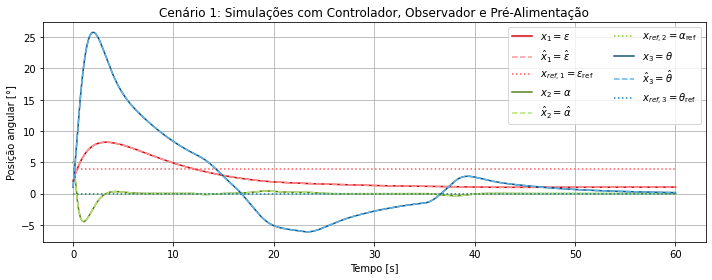

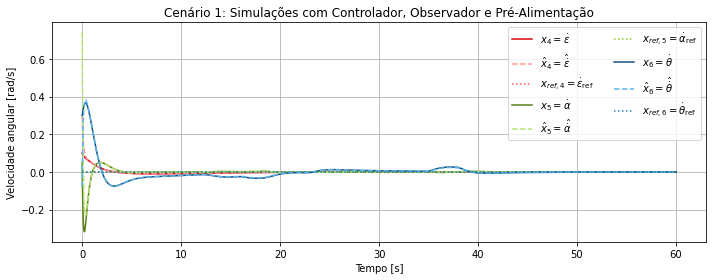

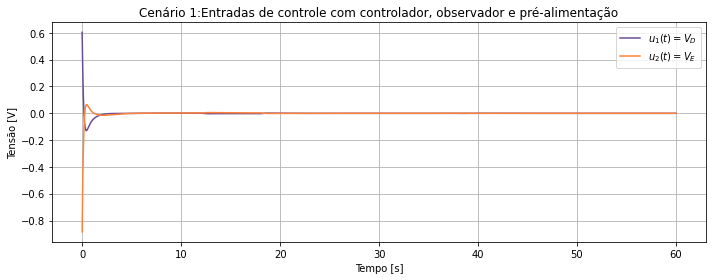

In [1583]:
simulacao_completa(cenario1, T=60, title='Cenário 1')

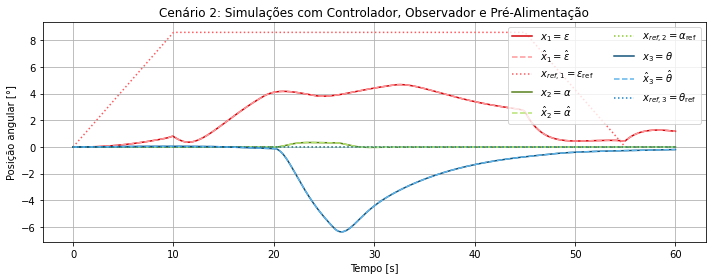

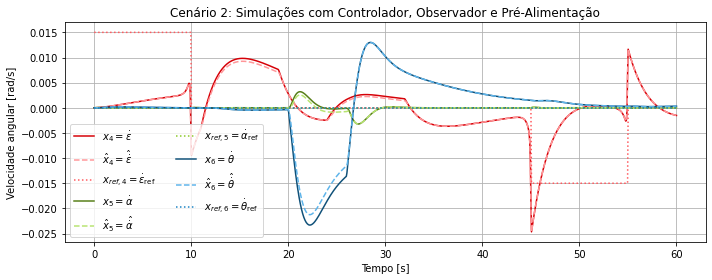

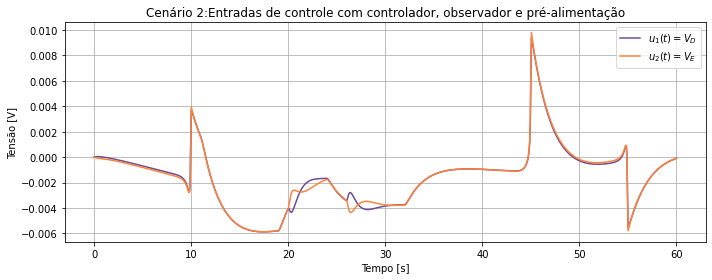

In [1584]:
simulacao_completa(cenario2, T=60, title='Cenário 2')